## **Install and import libraries**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install -q gym==0.26.2
# !pip install -q highway-env
# !pip install -q moviepy --upgrade

In [4]:
# pip install gym

In [5]:
# !pip uninstall -y gym
# !pip install gymnasium torchvision


In [6]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import gymnasium as gym
import os
import base64, io
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm , t
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# Pytorch librearies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
# For visualization
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
plt.style.use('ggplot')

# **Define Class and Hyperparameters**

## Hyperparameters

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
𝛼 = 1e-3                # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [9]:
# Your project root path
path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"

# Ensure trailing slash for consistency
if not path_HW5.endswith("\\"):
    path_HW5 += "\\"

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device.type

'cpu'

## Class Neural Network Architecture

### Class Linear

In [11]:
class QNetwork_Linear(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork_Linear, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 125)
        self.fc2 = nn.Linear(125, 125)
        self.fc3 = nn.Linear(125, action_size)

    def forward(self, state):
        # Build a network that maps state -> action values
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### Class CNN

In [12]:
class QNetwork_CNN(nn.Module):

    def __init__(self, action_size, seed):
        super(QNetwork_CNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(38912,64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        # Build a network that maps state -> action values
        x = self.dropout(self.maxpool(self.relu(self.conv1(state))))
        x = self.dropout(self.maxpool(self.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Class Replay Buffer

In [13]:
class ReplayBuffer():

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        # Add a new experience to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return the current size of internal memory
        return len(self.memory)

## Class Agent

In [14]:
class Agent():

    def __init__(self, state_size, action_size, network_type, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.network_type = network_type
        # Q-Network
        if network_type=='linear' or network_type=='Linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        elif network_type=='cnn' or network_type=='CNN':
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        #resize image
        self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.BICUBIC), T.ToTensor()])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        screen = screen.permute(2,0,1)
        screen_resized = self.resize(screen).unsqueeze(0)
        return screen_resized

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0):
        if self.network_type=='linear' or self.network_type=='Linear':
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        elif self.network_type=='cnn' or self.network_type=='CNN':
            state = state.to(device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        #Update value parameters using given batch of experience tuples

        ## Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 𝛼)

    def soft_update(self, local_model, target_model, 𝛼):
        # Soft update model parameters. θ_target = 𝛼*θ_local + (1-𝛼)*θ_target
        ## local_model (PyTorch model): weights will be copied from
        ## target_model (PyTorch model): weights will be copied to
        ## 𝛼 (float): interpolation parameter
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(𝛼*local_param.data + (1-𝛼)*target_param.data)

## Class DQN

In [17]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from gymnasium.wrappers import RecordVideo

class DQN():
    def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
        raw_env = env.unwrapped
        self.env = raw_env
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        if hasattr(self.env, 'config'):
            self.env.config.update({
                "observation": {
                    "type": "Kinematics",
                    "vehicles_count": 5,
                    "features": ["presence", "x", "y", "vx", "vy"],
                    "absolute": False
                },
                "policy_frequency": 5 if env_name == 'highway-fast-v0' else 10,
                "screen_width": 600,
                "screen_height": 150,
                "centering_position": [0.3, 0.5],
                "scaling": 2.0
            })

    def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"[{self.env_name}] Starting to train agent with state ...")
        try:
            if n_iteration[0] != 1:
                reward_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
                if os.path.exists(reward_file):
                    self.df_reward = pd.read_excel(reward_file)
                else:
                    print(f"[{self.env_name}] Warning: Reward file {reward_file} not found, starting with empty DataFrame")
            for iter in tqdm(n_iteration, desc=f"[{self.env_name}] Iteration"):
                episodes_reward = []
                state_size = int(np.prod(self.env.observation_space.shape))
                action_size = self.env.action_space.n
                agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
                if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
                    try:
                        agent.qnetwork_local.load_state_dict(torch.load(
                            os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')))
                        agent.qnetwork_target.load_state_dict(torch.load(
                            os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')))
                    except Exception as e:
                        print(f"[{self.env_name}] Error loading transfer learning models: {str(e)}")
                os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
                eps = eps_start
                for episode_num in tqdm(range(1, n_training_episodes+1), desc=f"[{self.env_name}] Iter {iter} Episodes"):
                    eps = max(eps_end, eps_decay*eps)
                    state, _ = self.env.reset()
                    done = False
                    total_rewards_episode = 0
                    for step in range(max_step):
                        action = agent.act(state.ravel(), eps)
                        next_state, reward, terminated, truncated, _ = self.env.step(action)
                        total_rewards_episode += reward
                        agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
                        if terminated or truncated:
                            break
                        state = next_state
                    episodes_reward.append(total_rewards_episode)
                    print(f'\r[{self.env_name}] Episode {episode_num}\tAverage reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                    if episode_num % 100 == 0:
                        print(f'\r[{self.env_name}] Episode {episode_num}\tAverage reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                    if episode_num % 200 == 0:
                        torch.save(agent.qnetwork_local.state_dict(),
                                   os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(),
                                   os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))
                self.df_reward[f'Run_{iter}'] = episodes_reward
                self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            return self.df_reward
        except Exception as e:
            print(f"[{self.env_name}] Training error: {str(e)}")
            raise

    def train_with_observation(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"[{self.env_name}] Starting to train agent with observation ...")
        try:
            if n_iteration[0] != 1:
                reward_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
                if os.path.exists(reward_file):
                    self.df_reward = pd.read_excel(reward_file)
                else:
                    print(f"[{self.env_name}] Warning: Reward file {reward_file} not found, starting with empty DataFrame")
            for iter in tqdm(n_iteration, desc=f"[{self.env_name}] Iteration"):
                episodes_reward = []
                state_size = int(np.prod(self.env.observation_space.shape))
                action_size = self.env.action_space.n
                agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
                if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
                    try:
                        agent.qnetwork_local.load_state_dict(torch.load(
                            os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_local_{self.transfer_episode}.pth')))
                        agent.qnetwork_target.load_state_dict(torch.load(
                            os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_target_{self.transfer_episode}.pth')))
                    except Exception as e:
                        print(f"[{self.env_name}] Error loading transfer learning models: {str(e)}")
                os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
                eps = eps_start
                for episode_num in tqdm(range(1, n_training_episodes+1), desc=f"[{self.env_name}] Iter {iter} Episodes"):
                    eps = max(eps_end, eps_decay*eps)
                    self.env.reset()
                    last_screen = agent.get_screen(self.env.render())
                    current_screen = agent.get_screen(self.env.render())
                    observation = current_screen - last_screen
                    done = False
                    total_rewards_episode = 0
                    for step in range(max_step):
                        action = agent.act(observation, eps)
                        _, reward, terminated, truncated, _ = self.env.step(action)
                        total_rewards_episode += reward
                        last_screen = current_screen
                        current_screen = agent.get_screen(self.env.render())
                        next_observation = current_screen - last_screen
                        agent.step(observation, action, reward, next_observation, terminated or truncated)
                        if terminated or truncated:
                            break
                        observation = next_observation
                    episodes_reward.append(total_rewards_episode)
                    print(f'\r[{self.env_name}] Episode {episode_num}\tAverage reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                    if episode_num % 100 == 0:
                        print(f'\r[{self.env_name}] Episode {episode_num}\tAverage reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                    if episode_num % 200 == 0:
                        torch.save(agent.qnetwork_local.state_dict(),
                                   os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(),
                                   os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))
                self.df_reward[f'Run_{iter}'] = episodes_reward
                self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            return self.df_reward
        except Exception as e:
            print(f"[{self.env_name}] Training error: {str(e)}")
            raise

    def evaluation(self, video_path, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True):
        video_folder = os.path.dirname(video_path)
        os.makedirs(video_folder, exist_ok=True)
        env = RecordVideo(self.env, video_folder=video_folder, name_prefix=os.path.basename(video_path).split('.')[0])
        if hasattr(env.env, 'config'):
            env.env.config.update({
                "observation": {
                    "type": "Kinematics",
                    "vehicles_count": 5,
                    "features": ["presence", "x", "y", "vx", "vy"],
                    "absolute": False
                },
                "policy_frequency": 5 if self.env_name == 'highway-fast-v0' else 10,
                "screen_width": 600,
                "screen_height": 150,
                "centering_position": [0.3, 0.5],
                "scaling": 2.0
            })
        try:
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=11)
            if use_saved_model:
                model_local = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth')
                model_target = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth')
                if not (os.path.exists(model_local) and os.path.exists(model_target)):
                    raise FileNotFoundError(f"Model files not found: {model_local}, {model_target}")
                agent.qnetwork_local.load_state_dict(torch.load(model_local, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
                agent.qnetwork_target.load_state_dict(torch.load(model_target, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
            if evaluate_type == 'state':
                state, _ = env.reset()
            elif evaluate_type == 'observation':
                env.reset()
                last_screen = agent.get_screen(env.render())
                current_screen = agent.get_screen(env.render())
                state = current_screen - last_screen
            done = False
            step = 0
            sum_rewards = 0
            while not done:
                print(f'\r[{self.env_name}] step:{step}', end="")
                if evaluate_type == 'state':
                    action = agent.act(state.ravel(), eps=0.0)
                    state, reward, terminated, truncated, _ = env.step(action)
                elif evaluate_type == 'observation':
                    action = agent.act(state, eps=0.0)
                    _, reward, terminated, truncated, _ = env.step(action)
                    last_screen = current_screen
                    current_screen = agent.get_screen(env.render())
                    state = current_screen - last_screen
                sum_rewards += reward
                step += 1
                if terminated or truncated:
                    done = True
            print()
            return sum_rewards
        except Exception as e:
            print(f"[{self.env_name}] Evaluation error: {str(e)}")
            raise
        finally:
            env.close()

## Class Show and Plot

In [16]:
class show_and_plot():
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        mp4list = glob.glob(directory+'*.mp4')
        if len(mp4list) > 0:
            mp4 = directory+file_name
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            display.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 165px; width: 650px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            print("Could not find video")

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):

        n_iter, n_episode = episodes_rewards.shape

        smooth_reward = []

        for i in range(int(np.round((n_episode-window)/stride))+1):
            k = np.sum(episodes_rewards[:,i*stride:i*stride+window], axis=1) / window
            smooth_reward.append(k)

        smooth_reward = np.array(smooth_reward).T

        _ , n_smooth = smooth_reward.shape

        X =  range(1, stride*n_smooth+1, stride)

        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval =  1 - alpha
        if n_iter < 30:
            t_statistic = t.interval(interval, df = n_iter - 1)[1]
            ME = t_statistic * SE
        else:
            z_statistic = norm.interval(interval)[1]
            ME = z_statistic * SE


        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, (x_bar - ME), (x_bar + ME), alpha=alpha)
        ax.set_xlabel("Episodes", fontsize=13)
        ax.set_ylabel("Average reward", fontsize=13)
        ax.set_title(title + "\nwindow size={}, stride={}".format(window, stride), fontsize=15)
        return ax

# **Part 1**

In [ ]:
# !pip install highway-env


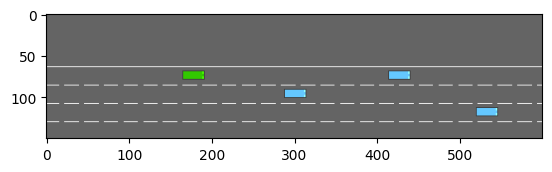

In [18]:
import highway_env
plt.style.use('default')
os.environ["SDL_VIDEODRIVER"] = "dummy"
env1 = gym.make('highway-v0', render_mode='rgb_array')
env1.reset()
env1.render()
os.environ['SDL_VIDEODRIVER'] = "x11"
env2 = gym.make('highway-v0', render_mode='rgb_array')
env2.reset()
plt.imshow(env2.render());
plt.style.use('ggplot')

In [19]:
print('Number of actions:', env2.action_space.n)
print('\nShape of states:', env2.observation_space.shape)
print('\nA sample of states:\n', env2.observation_space.sample())

Number of actions: 5

Shape of states: (5, 5)

A sample of states:
 [[ 1.321099    1.140384   -1.3147707   0.28247795 -0.38508114]
 [-1.2773387   0.5770059  -1.5413147   1.8805333   1.6884918 ]
 [ 0.8832446  -1.0261027  -0.00302906 -1.1664048   0.23046607]
 [ 0.4508345   0.04794608 -0.6377976   0.438505    0.19724411]
 [-1.2326833   0.5509935  -0.6529108   0.5367934   0.696613  ]]


In [20]:
env2.unwrapped.config


{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'normalize_reward': True,
 'offroad_terminal': False}

# **Part 2**

## merge-v0

In [21]:
# Part 2: merge-v0
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/1_Models_merge/'
data_path_1 = path_HW5 + 'Data_Average_Reward/1_Data_merge/'
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_merge = DQN(env, env_name, model_path, data_path_1, network_type='linear')

# Training
os.makedirs(os.path.join(model_path, 'Models_Run_1'), exist_ok=True)
os.makedirs(data_path_1, exist_ok=True)
df_reward_dqn_merge = dqn_merge.train_with_state(
    n_iteration=[1, 2, 3, 4, 5],  # 5 iterations
    n_training_episodes=200,
    max_step=100,
    eps_start=1.0,
    eps_end=0.001,
    eps_decay=0.995
)

# Evaluating
video_folder = os.path.join(path_HW5, "Videos")
os.makedirs(video_folder, exist_ok=True)
env = RecordVideo(dqn_merge.env, video_folder=video_folder, name_prefix="merge_iter_2")
if hasattr(env.env, 'config'):
    env.env.config['policy_frequency'] = 10
state_size = int(np.prod(dqn_merge.env.observation_space.shape))
action_size = dqn_merge.env.action_space.n
agent = Agent(state_size=state_size, action_size=action_size, network_type='linear', seed=11)
iter_num = 2
evaluate_episode_num = 200
try:
    agent.qnetwork_local.load_state_dict(
        torch.load(
            os.path.join(dqn_merge.model_path, f'Models_Run_{iter_num}/checkpoint_dqn_state_{dqn_merge.env_name}_local_{evaluate_episode_num}.pth'),
            map_location=torch.device(device.type)
        )
    )
    agent.qnetwork_target.load_state_dict(
        torch.load(
            os.path.join(dqn_merge.model_path, f'Models_Run_{iter_num}/checkpoint_dqn_state_{dqn_merge.env_name}_target_{evaluate_episode_num}.pth'),
            map_location=torch.device(device.type)
        )
    )
except FileNotFoundError:
    print(f"Error: Model files for iteration {iter_num}, episode {evaluate_episode_num} not found.")
    raise

total_rewards = 0
num_episodes = 20
for ep in range(num_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0
    while not done:
        action = agent.act(state.ravel(), eps=0.0)
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        done = terminated or truncated
    total_rewards += ep_reward
    print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward}")
env.close()
print(f"\nTotal reward over {num_episodes} episodes: {total_rewards}")
print(f"Average reward: {total_rewards / num_episodes}")
show_and_plot().show_video(directory=video_folder, file_name='merge_iter_2-episode-0.mp4')

[merge-v0] Starting to train agent with state ...
[merge-v0] Training error: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
import o 

In [ ]:
# video_path = path_HW5 + 'Videos/'
# model_path = path_HW5 + 'Models/1_Models_merge/'
# data_path_1 = path_HW5 + 'Data_Average_Reward/1_Data_merge/'
# env_name = 'merge-v0'
# env = gym.make(env_name, render_mode='rgb_array')
# dqn_merge = DQN(env, env_name, model_path, data_path_1, network_type='linear')

### Training

In [ ]:
# # !pip install openpyxl
# !pip install pyvirtualdisplay


In [ ]:
# from tqdm import tqdm  # Standard tqdm for console progress bars

# class DQN:
#     def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
#         print("Starting to train agent with state ...")
#         if n_iteration[0] != 1:
#             self.df_reward = pd.read_excel(os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx'))

#         for iter in tqdm(n_iteration, desc="Iteration"):
#             episodes_reward = []
#             state_size = int(np.prod(self.env.observation_space.shape))
#             action_size = self.env.action_space.n
#             agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
#             if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
#                 agent.qnetwork_local.load_state_dict(torch.load(
#                     os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')))
#                 agent.qnetwork_target.load_state_dict(torch.load(
#                     os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')))
#             models_run_path = os.path.join(self.model_path, f'Models_Run_{iter}')
#             os.makedirs(models_run_path, exist_ok=True)  # Ensure directory exists
#             eps = eps_start

#             for episode_num in tqdm(range(1, n_training_episodes+1), desc=f"Iter {iter} Episodes"):
#                 eps = max(eps_end, eps_decay*eps)
#                 state = self.env.reset()[0]
#                 done = False
#                 total_rewards_episode = 0
#                 for step in range(max_step):
#                     action = agent.act(state.ravel(), eps)
#                     next_state, reward, done, _, _ = self.env.step(action)
#                     total_rewards_episode += reward
#                     agent.step(state.ravel(), action, reward, next_state.ravel(), done)
#                     if done:
#                         break
#                     state = next_state
#                 episodes_reward.append(total_rewards_episode)
#                 print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps), end='')
#                 if episode_num % 100 == 0:
#                     print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps))
#                 if episode_num % 200 == 0:
#                     torch.save(agent.qnetwork_local.state_dict(),
#                                os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
#                     torch.save(agent.qnetwork_target.state_dict(),
#                                os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))
#             self.df_reward[f'Run_{iter}'] = episodes_reward
#             self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
#         return self.df_reward
    



### Evaluating

In [ ]:
# import os
# import numpy as np
# from gymnasium.wrappers import RecordVideo

# # --- Paths ---
# video_folder = os.path.join(path_HW5, "Videos")
# os.makedirs(video_folder, exist_ok=True)

# # --- Wrap environment with RecordVideo ---
# env = RecordVideo(dqn_merge.env, video_folder=video_folder, name_prefix="merge_iter_2")

# # Optional: adjust config if it exists
# if hasattr(env.env, 'config'):
#     env.env.config['policy_frequency'] = 10

# # --- Initialize Agent for evaluation ---
# state_size = int(np.prod(dqn_merge.env.observation_space.shape))
# action_size = dqn_merge.env.action_space.n
# agent = Agent(state_size=state_size, action_size=action_size, network_type='linear', seed=11)  # Same seed as in DQN.evaluation

# # Load saved model weights (adjust iter_num and episode_num to match your trained model)
# iter_num = 2  # Example: iteration number used in training
# evaluate_episode_num = 200  # Example: episode number where model was saved
# try:
#     agent.qnetwork_local.load_state_dict(
#         torch.load(
#             os.path.join(dqn_merge.model_path, f'Models_Run_{iter_num}/checkpoint_dqn_state_{dqn_merge.env_name}_local_{evaluate_episode_num}.pth'),
#             map_location=torch.device(device.type)
#         )
#     )
#     agent.qnetwork_target.load_state_dict(
#         torch.load(
#             os.path.join(dqn_merge.model_path, f'Models_Run_{iter_num}/checkpoint_dqn_state_{dqn_merge.env_name}_target_{evaluate_episode_num}.pth'),
#             map_location=torch.device(device.type)
#         )
#     )
# except FileNotFoundError:
#     print(f"Error: Model files for iteration {iter_num}, episode {evaluate_episode_num} not found. Ensure training completed and paths are correct.")
#     raise

# # --- Evaluation loop ---
# total_rewards = 0
# num_episodes = 20  # Reduced for testing; set to 2000 for full evaluation

# for ep in range(num_episodes):
#     state, _ = env.reset()
#     done = False
#     ep_reward = 0
    
#     while not done:
#         # Use Agent's act method with epsilon=0 (greedy policy for evaluation)
#         action = agent.act(state.ravel(), eps=0.0)  # FIXED: Use agent.act, not dqn_merge.act
#         state, reward, terminated, truncated, info = env.step(action)
#         ep_reward += reward
#         done = terminated or truncated
    
#     total_rewards += ep_reward
#     print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward}")

# env.close()

# print(f"\nTotal reward over {num_episodes} episodes: {total_rewards}")
# print(f"Average reward: {total_rewards / num_episodes}")

# # Display the video
# show_and_plot().show_video(directory=video_folder, file_name='merge_iter_2-episode-0.mp4')  # Adjust file name based on RecordVideo output

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

Exception ignored in: <function tqdm.__del__ at 0x000002A0268D9580>
Traceback (most recent call last):
  File "C:\Users\Harsh raj\AppData\Roaming\Python\Python313\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\Harsh raj\AppData\Roaming\Python\Python313\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

In [ ]:

# from gymnasium.wrappers import RecordVideo

# # Paths
# path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
# video_path = os.path.join(path_HW5, 'Videos')
# model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
# data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
# env_name = 'highway-fast-v0'

# # Test rendering
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# env_test = gym.make(env_name, render_mode='rgb_array')
# obs, _ = env_test.reset()
# frame = env_test.render()
# env_test.close()
# print("Frame shape:", frame.shape if frame is not None else "None")
# print("Frame sample:", frame[0, 0, :] if frame is not None else "None")
# if frame is None or np.all(frame == 0):
#     print("Warning: Rendering produced empty or black frames")

# # Evaluation
# env = gym.make(env_name, render_mode='rgb_array')
# env = RecordVideo(env, video_folder=video_path, name_prefix="fastHighway", episode_trigger=lambda x: True)
# if hasattr(env.env, 'config'):
#     env.env.config['policy_frequency'] = 5
# dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, network_type='linear')
# sum_rewards = dqn_fastHighway.evaluation(
#     video_path=os.path.join(video_path, "fastHighway.mp4"),
#     evaluate_type='state',
#     iter_num=1,
#     evaluate_episode_num=200,
#     use_saved_model=True
# )
# print('\n\nSum rewards in one EPISODE:', sum_rewards)

# # Display video
# show_and_plot().show_video(directory=video_path, file_name='fastHighway-episode-0.mp4')

Frame shape: (150, 600, 3)
Frame sample: [0 0 0]
step:20

Sum rewards in one EPISODE: 19.679306717582836
Could not find video


In [ ]:
# import os
# import gymnasium as gym
# import pygame
# import sys

# try:
#     os.environ["SDL_VIDEODRIVER"] = "windows"  # Native Windows driver
#     env = gym.make('highway-fast-v0', render_mode='human')
#     obs, _ = env.reset()
#     print("Environment reset successfully")
#     for step in range(100):
#         action = env.action_space.sample()
#         obs, reward, done, truncated, info = env.step(action)
#         frame = env.render()
#         print(f"Step {step}: Render returned {type(frame)}")
#         if done or truncated:
#             obs, _ = env.reset()
#     env.close()
# except Exception as e:
#     print(f"Error during rendering: {str(e)}")
# finally:
#     pygame.quit()

Environment reset successfully
Step 0: Render returned <class 'NoneType'>
Step 1: Render returned <class 'NoneType'>
Step 2: Render returned <class 'NoneType'>
Step 3: Render returned <class 'NoneType'>
Step 4: Render returned <class 'NoneType'>
Step 5: Render returned <class 'NoneType'>
Step 6: Render returned <class 'NoneType'>
Step 7: Render returned <class 'NoneType'>
Step 8: Render returned <class 'NoneType'>
Step 9: Render returned <class 'NoneType'>
Step 10: Render returned <class 'NoneType'>
Step 11: Render returned <class 'NoneType'>
Step 12: Render returned <class 'NoneType'>
Step 13: Render returned <class 'NoneType'>
Step 14: Render returned <class 'NoneType'>
Step 15: Render returned <class 'NoneType'>
Step 16: Render returned <class 'NoneType'>
Step 17: Render returned <class 'NoneType'>
Step 18: Render returned <class 'NoneType'>
Step 19: Render returned <class 'NoneType'>
Step 20: Render returned <class 'NoneType'>
Step 21: Render returned <class 'NoneType'>
Step 22: Re

In [ ]:
class show_and_plot:
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        # Ensure directory ends with separator
        if not directory.endswith(os.path.sep):
            directory += os.path.sep
        print(f"Directory: {directory}")
        mp4list = glob.glob(directory + '*.mp4')
        print(f"Found files: {mp4list}")
        if len(mp4list) > 0:
            mp4 = os.path.join(directory, file_name)
            print(f"Trying to open: {mp4}")
            if os.path.exists(mp4):
                video = io.open(mp4, 'r+b').read()
                encoded = base64.b64encode(video)
                display.display(HTML(data='''<video alt="test" autoplay
                        loop controls style="height: 165px; width: 650px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            else:
                print(f"File {mp4} does not exist")
        else:
            print("Could not find any .mp4 files in directory")
            
video_folder = os.path.join(
    r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks",
    "Videos"
)
show_and_plot().show_video(directory=video_folder, file_name='merge_iter_2-episode-8.mp4')

Directory: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\
Found files: ['C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\fastHighway-episode-0.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\fastHighway-episode-1.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\fastHighway.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\fastHighway_transferred_from_merge.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Rei

In [ ]:
# import os
# import gymnasium as gym
# import numpy as np
# import imageio

# path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
# video_path = os.path.join(path_HW5, 'Videos')
# os.makedirs(video_path, exist_ok=True)

# os.environ.pop("SDL_VIDEODRIVER", None)  # Remove dummy driver
# env = gym.make('highway-fast-v0', render_mode='rgb_array')
# # Configure environment
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 5,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# try:
#     obs, _ = env.reset()
#     print("Environment reset successfully")
#     frame = env.render()
#     print("Frame shape:", frame.shape if frame is not None else "None")
#     print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
#     print("Frame mean:", np.mean(frame) if frame is not None else "None")
#     if frame is not None and not np.all(frame == 0):
#         imageio.imwrite(os.path.join(video_path, 'debug_frame_highway-fast-v0.png'), frame)
#         print("Saved debug_frame_highway-fast-v0.png")
#     else:
#         print("Warning: Black or empty frame")
# except Exception as e:
#     print(f"Error during rendering: {str(e)}")
# finally:
#     env.close()

# # Repeat for merge-v0
# env = gym.make('merge-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# try:
#     obs, _ = env.reset()
#     print("Environment reset successfully")
#     frame = env.render()
#     print("Frame shape:", frame.shape if frame is not None else "None")
#     print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
#     print("Frame mean:", np.mean(frame) if frame is not None else "None")
#     if frame is not None and not np.all(frame == 0):
#         imageio.imwrite(os.path.join(video_path, 'debug_frame_merge-v0.png'), frame)
#         print("Saved debug_frame_merge-v0.png")
#     else:
#         print("Warning: Black or empty frame")
# except Exception as e:
#     print(f"Error during rendering: {str(e)}")
# finally:
#     env.close()

# # Repeat for highway-v0
# env = gym.make('highway-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# try:
#     obs, _ = env.reset()
#     print("Environment reset successfully")
#     frame = env.render()
#     print("Frame shape:", frame.shape if frame is not None else "None")
#     print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
#     print("Frame mean:", np.mean(frame) if frame is not None else "None")
#     if frame is not None and not np.all(frame == 0):
#         imageio.imwrite(os.path.join(video_path, 'debug_frame_highway-v0.png'), frame)
#         print("Saved debug_frame_highway-v0.png")
#     else:
#         print("Warning: Black or empty frame")
# except Exception as e:
#     print(f"Error during rendering: {str(e)}")
# finally:
#     env.close()

Environment reset successfully
Frame shape: (150, 600, 3)
Frame sample (top-left): [100 100 100]
Frame mean: 102.8235
Saved debug_frame_highway-fast-v0.png
Environment reset successfully
Frame shape: (150, 600, 3)
Frame sample (top-left): [100 100 100]
Frame mean: 102.5111111111111
Saved debug_frame_merge-v0.png
Environment reset successfully
Frame shape: (150, 600, 3)
Frame sample (top-left): [100 100 100]
Frame mean: 103.74288888888888
Saved debug_frame_highway-v0.png


## **Plotting**

In [ ]:
import glob
import base64
import io
from IPython.display import HTML
from scipy.stats import norm, t
import matplotlib.pyplot as plt

class show_and_plot:
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        # Ensure directory ends with separator
        if not directory.endswith(os.path.sep):
            directory += os.path.sep
        print(f"Directory: {directory}")
        mp4list = glob.glob(directory + '*.mp4')
        print(f"Found files: {mp4list}")
        if len(mp4list) > 0:
            mp4 = os.path.join(directory, file_name)
            print(f"Trying to open: {mp4}")
            if os.path.exists(mp4):
                video = io.open(mp4, 'r+b').read()
                encoded = base64.b64encode(video)
                display.display(HTML(data='''<video alt="test" autoplay
                        loop controls style="height: 165px; width: 650px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            else:
                print(f"File {mp4} does not exist")
        else:
            print("Could not find any .mp4 files in directory")

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = []
        for i in range(int(np.round((n_episode - window) / stride)) + 1):
            k = np.sum(episodes_rewards[:, i * stride:i * stride + window], axis=1) / window
            smooth_reward.append(k)
        smooth_reward = np.array(smooth_reward).T
        _, n_smooth = smooth_reward.shape
        X = range(1, stride * n_smooth + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval = 1 - alpha
        if n_iter < 30:
            t_statistic = t.interval(interval, df=n_iter - 1)[1]
            ME = t_statistic * SE
        else:
            z_statistic = norm.interval(interval)[1]
            ME = z_statistic * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, (x_bar - ME), (x_bar + ME), alpha=alpha)
        ax.set_xlabel("Episodes", fontsize=13)
        ax.set_ylabel("Average reward", fontsize=13)
        ax.set_title(title + "\nwindow size={}, stride={}".format(window, stride), fontsize=15)
        return ax

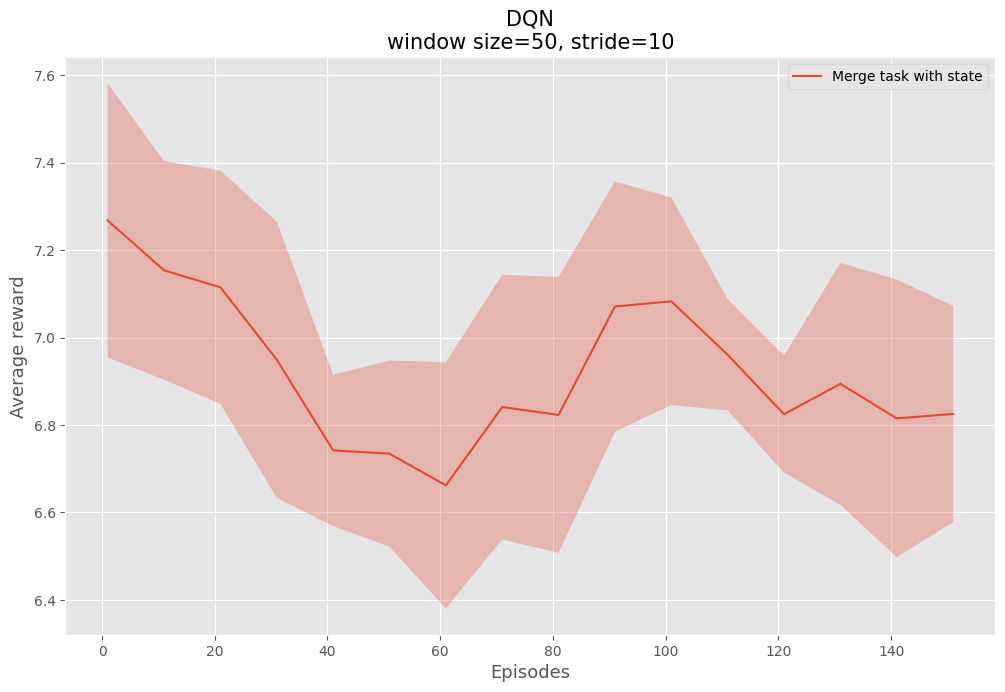

In [ ]:


# Define paths
path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')

# Load rewards
df_reward_dqn_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_5.xlsx'))
episodes_rewards_merge = df_reward_dqn_merge.T.to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(12, 7.5))
ax = show_and_plot().plot_training_result(
    episodes_rewards_merge, ax, title='DQN', label='Merge task with state',
    window=50, stride=10, alpha=0.3
)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)

# **Part 3**

## highway-fast-v0

In [ ]:
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/2_Models_fastHighway/'
data_path_2 = path_HW5 + 'Data_Average_Reward/2_Data_fastHighway/'
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, network_type='linear')

TypeError: DQN() takes no arguments

### Training

In [ ]:
df_reward_dqn_fastHighway = dqn_fastHighway.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Episode 2	Average reward: 2.23	Epsilon: 0.990

Episode 4	Average reward: 5.28	Epsilon: 0.980

Episode 5	Average reward: 12.99	Epsilon: 0.975

Episode 7	Average reward: 11.33	Epsilon: 0.966

Episode 8	Average reward: 11.81	Epsilon: 0.961

Episode 10	Average reward: 10.63	Epsilon: 0.951

Episode 11	Average reward: 9.88	Epsilon: 0.946

Episode 13	Average reward: 9.41	Epsilon: 0.937

Episode 14	Average reward: 8.92	Epsilon: 0.932

Episode 16	Average reward: 8.47	Epsilon: 0.923

Episode 17	Average reward: 8.24	Epsilon: 0.918

Episode 18	Average reward: 8.68	Epsilon: 0.914

Episode 19	Average reward: 9.27	Epsilon: 0.909

Episode 21	Average reward: 8.91	Epsilon: 0.900

Episode 22	Average reward: 9.00	Epsilon: 0.896

Episode 24	Average reward: 8.65	Epsilon: 0.887

Episode 26	Average reward: 8.25	Epsilon: 0.878

Episode 27	Average reward: 8.01	Epsilon: 0.873

Episode 28	Average reward: 8.02	Epsilon: 0.869

Episode 29	Average reward: 7.94	Epsilon: 0.865

Episode 31	Average reward: 7.65	Epsilon: 0.856

Episode 33	Average reward: 7.40	Epsilon: 0.848

Episode 34	Average reward: 7.66	Epsilon: 0.843

Episode 35	Average reward: 7.96	Epsilon: 0.839

Episode 36	Average reward: 7.88	Epsilon: 0.835

Episode 37	Average reward: 7.90	Epsilon: 0.831

Episode 38	Average reward: 7.96	Epsilon: 0.827

Episode 39	Average reward: 8.03	Epsilon: 0.822

Episode 41	Average reward: 8.03	Epsilon: 0.814

Episode 43	Average reward: 7.86	Epsilon: 0.806

Episode 44	Average reward: 7.80	Epsilon: 0.802

Episode 45	Average reward: 7.74	Epsilon: 0.798

Episode 47	Average reward: 7.61	Epsilon: 0.790

Episode 48	Average reward: 7.52	Epsilon: 0.786

Episode 50	Average reward: 7.45	Epsilon: 0.778

Episode 51	Average reward: 7.49	Epsilon: 0.774

Episode 53	Average reward: 7.35	Epsilon: 0.767

Episode 55	Average reward: 7.49	Epsilon: 0.759

Episode 56	Average reward: 7.48	Epsilon: 0.755

Episode 57	Average reward: 7.43	Epsilon: 0.751

Episode 59	Average reward: 7.35	Epsilon: 0.744

Episode 60	Average reward: 7.33	Epsilon: 0.740

Episode 61	Average reward: 7.33	Epsilon: 0.737

Episode 62	Average reward: 7.44	Epsilon: 0.733

Episode 64	Average reward: 7.36	Epsilon: 0.726

Episode 65	Average reward: 7.42	Epsilon: 0.722

Episode 66	Average reward: 7.50	Epsilon: 0.718

Episode 67	Average reward: 7.53	Epsilon: 0.715

Episode 69	Average reward: 7.45	Epsilon: 0.708

Episode 70	Average reward: 7.46	Epsilon: 0.704

Episode 72	Average reward: 7.71	Epsilon: 0.697

Episode 73	Average reward: 7.74	Epsilon: 0.694

Episode 75	Average reward: 7.69	Epsilon: 0.687

Episode 77	Average reward: 7.73	Epsilon: 0.680

Episode 80	Average reward: 7.53	Epsilon: 0.670

Episode 82	Average reward: 7.44	Epsilon: 0.663

Episode 83	Average reward: 7.42	Epsilon: 0.660

Episode 84	Average reward: 7.44	Epsilon: 0.656

Episode 85	Average reward: 7.39	Epsilon: 0.653

Episode 86	Average reward: 7.37	Epsilon: 0.650

Episode 87	Average reward: 7.45	Epsilon: 0.647

Episode 88	Average reward: 7.49	Epsilon: 0.643

Episode 89	Average reward: 7.57	Epsilon: 0.640

Episode 90	Average reward: 7.50	Epsilon: 0.637

Episode 91	Average reward: 7.51	Epsilon: 0.634

Episode 92	Average reward: 7.45	Epsilon: 0.631

Episode 93	Average reward: 7.39	Epsilon: 0.627

Episode 94	Average reward: 7.44	Epsilon: 0.624

Episode 95	Average reward: 7.40	Epsilon: 0.621

Episode 96	Average reward: 7.37	Epsilon: 0.618

Episode 97	Average reward: 7.41	Epsilon: 0.615

Episode 98	Average reward: 7.37	Epsilon: 0.612

Episode 99	Average reward: 7.45	Epsilon: 0.609

Episode 100	Average reward: 7.47	Epsilon: 0.606


Episode 101	Average reward: 7.43	Epsilon: 0.603

Episode 102	Average reward: 7.44	Epsilon: 0.600

Episode 103	Average reward: 7.43	Epsilon: 0.597

Episode 104	Average reward: 7.47	Epsilon: 0.594

Episode 105	Average reward: 7.47	Epsilon: 0.591

Episode 106	Average reward: 7.43	Epsilon: 0.588

Episode 107	Average reward: 7.43	Epsilon: 0.585

Episode 108	Average reward: 7.44	Epsilon: 0.582

Episode 109	Average reward: 7.38	Epsilon: 0.579

Episode 110	Average reward: 7.34	Epsilon: 0.576

Episode 111	Average reward: 7.35	Epsilon: 0.573

Episode 112	Average reward: 7.32	Epsilon: 0.570

Episode 113	Average reward: 7.35	Epsilon: 0.568

Episode 114	Average reward: 7.34	Epsilon: 0.565

Episode 115	Average reward: 7.32	Epsilon: 0.562

Episode 116	Average reward: 7.29	Epsilon: 0.559

Episode 117	Average reward: 7.33	Epsilon: 0.556

Episode 118	Average reward: 7.29	Epsilon: 0.554

Episode 119	Average reward: 7.24	Epsilon: 0.551

Episode 120	Average reward: 7.20	Epsilon: 0.548

Episode 121	Average reward: 7.23	Epsilon: 0.545

Episode 122	Average reward: 7.21	Epsilon: 0.543

Episode 123	Average reward: 7.19	Epsilon: 0.540

Episode 124	Average reward: 7.16	Epsilon: 0.537

Episode 125	Average reward: 7.17	Epsilon: 0.534

Episode 126	Average reward: 7.27	Epsilon: 0.532

Episode 127	Average reward: 7.24	Epsilon: 0.529

Episode 128	Average reward: 7.26	Epsilon: 0.526

Episode 129	Average reward: 7.28	Epsilon: 0.524

Episode 130	Average reward: 7.26	Epsilon: 0.521

Episode 131	Average reward: 7.28	Epsilon: 0.519

Episode 132	Average reward: 7.31	Epsilon: 0.516

Episode 133	Average reward: 7.30	Epsilon: 0.513

Episode 134	Average reward: 7.31	Epsilon: 0.511

Episode 136	Average reward: 7.23	Epsilon: 0.506

Episode 138	Average reward: 7.16	Epsilon: 0.501

Episode 140	Average reward: 7.11	Epsilon: 0.496

Episode 141	Average reward: 7.16	Epsilon: 0.493

Episode 143	Average reward: 7.11	Epsilon: 0.488

Episode 145	Average reward: 7.08	Epsilon: 0.483

Episode 146	Average reward: 7.05	Epsilon: 0.481

Episode 148	Average reward: 7.04	Epsilon: 0.476

Episode 149	Average reward: 7.02	Epsilon: 0.474

Episode 151	Average reward: 7.00	Epsilon: 0.469

Episode 152	Average reward: 7.00	Epsilon: 0.467

Episode 153	Average reward: 7.02	Epsilon: 0.464

Episode 154	Average reward: 7.02	Epsilon: 0.462

Episode 156	Average reward: 7.02	Epsilon: 0.458

Episode 158	Average reward: 7.00	Epsilon: 0.453

Episode 160	Average reward: 7.01	Epsilon: 0.448

Episode 162	Average reward: 6.98	Epsilon: 0.444

Episode 164	Average reward: 6.97	Epsilon: 0.440

Episode 165	Average reward: 6.97	Epsilon: 0.437

Episode 166	Average reward: 6.99	Epsilon: 0.435

Episode 167	Average reward: 7.01	Epsilon: 0.433

Episode 169	Average reward: 6.99	Epsilon: 0.429

Episode 170	Average reward: 7.03	Epsilon: 0.427

Episode 171	Average reward: 7.03	Epsilon: 0.424

Episode 172	Average reward: 7.05	Epsilon: 0.422

Episode 173	Average reward: 7.06	Epsilon: 0.420

Episode 174	Average reward: 7.06	Epsilon: 0.418

Episode 176	Average reward: 7.03	Epsilon: 0.414

Episode 177	Average reward: 7.01	Epsilon: 0.412

Episode 178	Average reward: 7.03	Epsilon: 0.410

Episode 179	Average reward: 7.04	Epsilon: 0.408

Episode 180	Average reward: 7.05	Epsilon: 0.406

Episode 181	Average reward: 7.07	Epsilon: 0.404

Episode 182	Average reward: 7.09	Epsilon: 0.402

Episode 184	Average reward: 7.11	Epsilon: 0.398

Episode 185	Average reward: 7.12	Epsilon: 0.396

Episode 187	Average reward: 7.09	Epsilon: 0.392

Episode 188	Average reward: 7.08	Epsilon: 0.390

Episode 190	Average reward: 7.06	Epsilon: 0.386

Episode 192	Average reward: 7.07	Epsilon: 0.382

Episode 193	Average reward: 7.05	Epsilon: 0.380

Episode 194	Average reward: 7.07	Epsilon: 0.378

Episode 195	Average reward: 7.06	Epsilon: 0.376

Episode 197	Average reward: 7.06	Epsilon: 0.373

Episode 198	Average reward: 7.06	Epsilon: 0.371

Episode 200	Average reward: 7.05	Epsilon: 0.367


Episode 201	Average reward: 7.04	Epsilon: 0.365

Episode 203	Average reward: 7.07	Epsilon: 0.361

Episode 204	Average reward: 7.08	Epsilon: 0.360

Episode 205	Average reward: 7.08	Epsilon: 0.358

Episode 207	Average reward: 7.07	Epsilon: 0.354

Episode 209	Average reward: 7.06	Epsilon: 0.351

Episode 211	Average reward: 7.04	Epsilon: 0.347

Episode 212	Average reward: 7.05	Epsilon: 0.346

Episode 214	Average reward: 7.06	Epsilon: 0.342

Episode 217	Average reward: 7.04	Epsilon: 0.337

Episode 218	Average reward: 7.03	Epsilon: 0.335

Episode 219	Average reward: 7.05	Epsilon: 0.334

Episode 220	Average reward: 7.04	Epsilon: 0.332

Episode 222	Average reward: 7.02	Epsilon: 0.329

Episode 224	Average reward: 6.98	Epsilon: 0.325

Episode 226	Average reward: 6.95	Epsilon: 0.322

Episode 227	Average reward: 6.95	Epsilon: 0.321

Episode 228	Average reward: 6.98	Epsilon: 0.319

Episode 229	Average reward: 7.00	Epsilon: 0.317

Episode 230	Average reward: 7.02	Epsilon: 0.316

Episode 232	Average reward: 7.03	Epsilon: 0.313

Episode 235	Average reward: 7.00	Epsilon: 0.308

Episode 236	Average reward: 6.99	Epsilon: 0.306

Episode 237	Average reward: 6.98	Epsilon: 0.305

Episode 238	Average reward: 7.01	Epsilon: 0.303

Episode 239	Average reward: 7.05	Epsilon: 0.302

Episode 240	Average reward: 7.09	Epsilon: 0.300

Episode 241	Average reward: 7.08	Epsilon: 0.299

Episode 243	Average reward: 7.07	Epsilon: 0.296

Episode 244	Average reward: 7.09	Epsilon: 0.294

Episode 246	Average reward: 7.12	Epsilon: 0.291

Episode 248	Average reward: 7.16	Epsilon: 0.288

Episode 249	Average reward: 7.14	Epsilon: 0.287

Episode 251	Average reward: 7.12	Epsilon: 0.284

Episode 253	Average reward: 7.12	Epsilon: 0.281

Iter 1 Episodes:   7%|▋         | 253/3600 [01:40<14:01,  3.98it/s]

Episode 255	Average reward: 7.13	Epsilon: 0.279

Episode 256	Average reward: 7.11	Epsilon: 0.277

Episode 258	Average reward: 7.09	Epsilon: 0.274

Episode 260	Average reward: 7.06	Epsilon: 0.272

Episode 263	Average reward: 7.01	Epsilon: 0.268

Episode 265	Average reward: 7.00	Epsilon: 0.265

Episode 266	Average reward: 7.00	Epsilon: 0.264

Episode 268	Average reward: 6.98	Epsilon: 0.261

Episode 269	Average reward: 6.97	Epsilon: 0.260

Episode 270	Average reward: 7.00	Epsilon: 0.258

Episode 271	Average reward: 6.99	Epsilon: 0.257

Episode 273	Average reward: 6.98	Epsilon: 0.255

Episode 274	Average reward: 6.96	Epsilon: 0.253

Episode 275	Average reward: 6.99	Epsilon: 0.252

Episode 276	Average reward: 7.02	Epsilon: 0.251

Episode 278	Average reward: 7.00	Epsilon: 0.248

Episode 279	Average reward: 7.00	Epsilon: 0.247

Episode 280	Average reward: 7.01	Epsilon: 0.246

Episode 282	Average reward: 7.00	Epsilon: 0.243

Episode 284	Average reward: 7.02	Epsilon: 0.241

Episode 285	Average reward: 7.11	Epsilon: 0.240

Episode 286	Average reward: 7.14	Epsilon: 0.238

Episode 287	Average reward: 7.15	Epsilon: 0.237

Episode 289	Average reward: 7.13	Epsilon: 0.235

Episode 291	Average reward: 7.13	Epsilon: 0.233

Episode 292	Average reward: 7.11	Epsilon: 0.231

Episode 293	Average reward: 7.11	Epsilon: 0.230

Episode 296	Average reward: 7.08	Epsilon: 0.227

Episode 298	Average reward: 7.05	Epsilon: 0.225

Episode 300	Average reward: 7.06	Epsilon: 0.222


Episode 301	Average reward: 7.05	Epsilon: 0.221

Episode 302	Average reward: 7.06	Epsilon: 0.220

Episode 303	Average reward: 7.06	Epsilon: 0.219

Episode 304	Average reward: 7.06	Epsilon: 0.218

Episode 305	Average reward: 7.06	Epsilon: 0.217

Episode 308	Average reward: 7.03	Epsilon: 0.214

Episode 309	Average reward: 7.03	Epsilon: 0.212

Episode 312	Average reward: 7.00	Epsilon: 0.209

Episode 313	Average reward: 7.02	Epsilon: 0.208

Episode 314	Average reward: 7.04	Epsilon: 0.207

Episode 315	Average reward: 7.03	Epsilon: 0.206

Episode 316	Average reward: 7.02	Epsilon: 0.205

Episode 317	Average reward: 7.02	Epsilon: 0.204

Episode 318	Average reward: 7.01	Epsilon: 0.203

Episode 319	Average reward: 7.02	Epsilon: 0.202

Episode 320	Average reward: 7.02	Epsilon: 0.201

Episode 321	Average reward: 7.03	Epsilon: 0.200

Episode 322	Average reward: 7.02	Epsilon: 0.199

Episode 323	Average reward: 7.03	Epsilon: 0.198

Episode 324	Average reward: 7.01	Epsilon: 0.197

Episode 325	Average reward: 7.01	Epsilon: 0.196

Episode 326	Average reward: 7.02	Epsilon: 0.195

Episode 327	Average reward: 7.00	Epsilon: 0.194

Episode 328	Average reward: 7.01	Epsilon: 0.193

Episode 329	Average reward: 7.03	Epsilon: 0.192

Episode 330	Average reward: 7.03	Epsilon: 0.191

Episode 331	Average reward: 7.03	Epsilon: 0.190

Episode 332	Average reward: 7.04	Epsilon: 0.189

Episode 333	Average reward: 7.03	Epsilon: 0.188

Episode 334	Average reward: 7.01	Epsilon: 0.187

Episode 335	Average reward: 7.01	Epsilon: 0.187

Episode 336	Average reward: 7.01	Epsilon: 0.186

Episode 337	Average reward: 7.00	Epsilon: 0.185

Episode 338	Average reward: 7.00	Epsilon: 0.184

Episode 339	Average reward: 7.00	Epsilon: 0.183

Episode 340	Average reward: 7.00	Epsilon: 0.182

Episode 341	Average reward: 7.00	Epsilon: 0.181

Episode 342	Average reward: 7.02	Epsilon: 0.180

Episode 343	Average reward: 7.03	Epsilon: 0.179

Episode 344	Average reward: 7.02	Epsilon: 0.178

Episode 345	Average reward: 7.01	Epsilon: 0.177

Episode 346	Average reward: 7.00	Epsilon: 0.177

Episode 347	Average reward: 7.00	Epsilon: 0.176

Episode 348	Average reward: 7.00	Epsilon: 0.175

Episode 349	Average reward: 6.99	Epsilon: 0.174

Episode 350	Average reward: 6.97	Epsilon: 0.173

Episode 351	Average reward: 6.97	Epsilon: 0.172

Episode 352	Average reward: 6.96	Epsilon: 0.171

Episode 353	Average reward: 6.97	Epsilon: 0.170

Episode 354	Average reward: 7.01	Epsilon: 0.170

Episode 355	Average reward: 7.01	Epsilon: 0.169

Episode 356	Average reward: 7.02	Epsilon: 0.168

Episode 357	Average reward: 7.02	Epsilon: 0.167

Episode 358	Average reward: 7.02	Epsilon: 0.166

Episode 359	Average reward: 7.03	Epsilon: 0.165

Episode 360	Average reward: 7.03	Epsilon: 0.165

Episode 361	Average reward: 7.03	Epsilon: 0.164

Episode 362	Average reward: 7.02	Epsilon: 0.163

Episode 363	Average reward: 7.02	Epsilon: 0.162

Episode 364	Average reward: 7.01	Epsilon: 0.161

Episode 365	Average reward: 7.00	Epsilon: 0.160

Episode 366	Average reward: 7.01	Epsilon: 0.160

Episode 367	Average reward: 6.99	Epsilon: 0.159

Episode 368	Average reward: 6.99	Epsilon: 0.158

Episode 369	Average reward: 6.98	Epsilon: 0.157

Episode 370	Average reward: 6.99	Epsilon: 0.157

Episode 371	Average reward: 6.98	Epsilon: 0.156

Episode 372	Average reward: 6.98	Epsilon: 0.155

Episode 373	Average reward: 6.98	Epsilon: 0.154

Episode 374	Average reward: 6.99	Epsilon: 0.153

Episode 375	Average reward: 7.00	Epsilon: 0.153

Episode 376	Average reward: 7.01	Epsilon: 0.152

Episode 377	Average reward: 7.01	Epsilon: 0.151

Episode 378	Average reward: 6.99	Epsilon: 0.150

Episode 379	Average reward: 7.00	Epsilon: 0.150

Episode 380	Average reward: 7.00	Epsilon: 0.149

Episode 381	Average reward: 7.00	Epsilon: 0.148

Episode 382	Average reward: 7.01	Epsilon: 0.147

Episode 383	Average reward: 7.01	Epsilon: 0.147

Episode 384	Average reward: 7.00	Epsilon: 0.146

Episode 385	Average reward: 6.99	Epsilon: 0.145

Episode 386	Average reward: 7.00	Epsilon: 0.144

Episode 387	Average reward: 7.01	Epsilon: 0.144

Episode 388	Average reward: 7.01	Epsilon: 0.143

Episode 389	Average reward: 7.01	Epsilon: 0.142

Episode 391	Average reward: 6.99	Epsilon: 0.141

Episode 392	Average reward: 7.00	Epsilon: 0.140

Episode 393	Average reward: 6.99	Epsilon: 0.139

Episode 394	Average reward: 6.99	Epsilon: 0.139

Episode 396	Average reward: 6.99	Epsilon: 0.137

Episode 397	Average reward: 6.99	Epsilon: 0.137

Episode 398	Average reward: 7.00	Epsilon: 0.136

Episode 399	Average reward: 6.99	Epsilon: 0.135

Episode 400	Average reward: 7.03	Epsilon: 0.135
Episode 401	Average reward: 7.03	Epsilon: 0.134

Episode 402	Average reward: 7.06	Epsilon: 0.133

Episode 403	Average reward: 7.07	Epsilon: 0.133

Episode 404	Average reward: 7.07	Epsilon: 0.132

Episode 405	Average reward: 7.05	Epsilon: 0.131

Episode 406	Average reward: 7.06	Epsilon: 0.131

Episode 407	Average reward: 7.05	Epsilon: 0.130

Episode 408	Average reward: 7.04	Epsilon: 0.129

Episode 409	Average reward: 7.04	Epsilon: 0.129

Episode 410	Average reward: 7.03	Epsilon: 0.128

Episode 411	Average reward: 7.02	Epsilon: 0.127

Episode 412	Average reward: 7.03	Epsilon: 0.127

Episode 413	Average reward: 7.02	Epsilon: 0.126

Episode 414	Average reward: 7.02	Epsilon: 0.126

Episode 415	Average reward: 7.01	Epsilon: 0.125

Episode 416	Average reward: 7.01	Epsilon: 0.124

Episode 417	Average reward: 7.03	Epsilon: 0.124

Episode 418	Average reward: 7.02	Epsilon: 0.123

Episode 419	Average reward: 7.02	Epsilon: 0.122

Episode 420	Average reward: 7.03	Epsilon: 0.122

Episode 421	Average reward: 7.03	Epsilon: 0.121

Episode 422	Average reward: 7.04	Epsilon: 0.121

Episode 423	Average reward: 7.03	Epsilon: 0.120

Episode 424	Average reward: 7.03	Epsilon: 0.119

Episode 425	Average reward: 7.01	Epsilon: 0.119

Episode 426	Average reward: 7.01	Epsilon: 0.118

Episode 427	Average reward: 7.00	Epsilon: 0.118

Episode 428	Average reward: 7.00	Epsilon: 0.117

Episode 429	Average reward: 6.99	Epsilon: 0.116

Episode 430	Average reward: 6.98	Epsilon: 0.116

Episode 431	Average reward: 6.98	Epsilon: 0.115

Episode 432	Average reward: 6.97	Epsilon: 0.115

Episode 433	Average reward: 6.96	Epsilon: 0.114

Episode 434	Average reward: 6.94	Epsilon: 0.114

Episode 435	Average reward: 6.94	Epsilon: 0.113

Episode 436	Average reward: 6.94	Epsilon: 0.112

Episode 437	Average reward: 6.93	Epsilon: 0.112

Episode 438	Average reward: 6.94	Epsilon: 0.111

Episode 439	Average reward: 6.94	Epsilon: 0.111

Episode 440	Average reward: 6.96	Epsilon: 0.110

Episode 441	Average reward: 6.96	Epsilon: 0.110

Episode 442	Average reward: 6.96	Epsilon: 0.109

Episode 443	Average reward: 6.95	Epsilon: 0.109

Episode 444	Average reward: 6.95	Epsilon: 0.108

Episode 445	Average reward: 6.97	Epsilon: 0.107

Episode 446	Average reward: 6.97	Epsilon: 0.107

Episode 447	Average reward: 6.99	Epsilon: 0.106

Episode 448	Average reward: 6.98	Epsilon: 0.106

Episode 449	Average reward: 6.98	Epsilon: 0.105

Episode 450	Average reward: 6.97	Epsilon: 0.105

Episode 451	Average reward: 6.97	Epsilon: 0.104

Episode 452	Average reward: 6.96	Epsilon: 0.104

Episode 453	Average reward: 6.95	Epsilon: 0.103

Episode 454	Average reward: 6.95	Epsilon: 0.103

Episode 455	Average reward: 6.94	Epsilon: 0.102

Episode 456	Average reward: 6.95	Epsilon: 0.102

Episode 457	Average reward: 6.94	Epsilon: 0.101

Episode 458	Average reward: 6.94	Epsilon: 0.101

Episode 459	Average reward: 6.94	Epsilon: 0.100

Episode 460	Average reward: 6.93	Epsilon: 0.100

Episode 461	Average reward: 6.92	Epsilon: 0.099

Episode 462	Average reward: 6.93	Epsilon: 0.099

Episode 463	Average reward: 6.93	Epsilon: 0.098

Episode 464	Average reward: 6.92	Epsilon: 0.098

Episode 465	Average reward: 6.92	Epsilon: 0.097

Episode 466	Average reward: 6.92	Epsilon: 0.097

Episode 467	Average reward: 6.93	Epsilon: 0.096

Episode 468	Average reward: 6.93	Epsilon: 0.096

Episode 469	Average reward: 6.92	Epsilon: 0.095

Episode 470	Average reward: 6.91	Epsilon: 0.095

Episode 471	Average reward: 6.94	Epsilon: 0.094

Episode 472	Average reward: 6.93	Epsilon: 0.094

Episode 473	Average reward: 6.92	Epsilon: 0.093

Episode 474	Average reward: 6.91	Epsilon: 0.093

Episode 475	Average reward: 6.92	Epsilon: 0.092

Episode 476	Average reward: 6.94	Epsilon: 0.092

Episode 477	Average reward: 6.94	Epsilon: 0.092

Episode 478	Average reward: 6.95	Epsilon: 0.091

Episode 479	Average reward: 6.96	Epsilon: 0.091

Episode 480	Average reward: 6.96	Epsilon: 0.090

Episode 481	Average reward: 6.97	Epsilon: 0.090

Episode 482	Average reward: 6.97	Epsilon: 0.089

Episode 483	Average reward: 6.96	Epsilon: 0.089

Episode 484	Average reward: 6.96	Epsilon: 0.088

Episode 485	Average reward: 6.95	Epsilon: 0.088

Episode 486	Average reward: 6.97	Epsilon: 0.088

Episode 488	Average reward: 6.96	Epsilon: 0.087

Episode 490	Average reward: 6.95	Epsilon: 0.086

Episode 491	Average reward: 6.95	Epsilon: 0.085

Episode 492	Average reward: 6.95	Epsilon: 0.085

Episode 493	Average reward: 6.96	Epsilon: 0.084

Episode 494	Average reward: 6.96	Epsilon: 0.084

Episode 496	Average reward: 6.94	Epsilon: 0.083

Episode 497	Average reward: 6.97	Epsilon: 0.083

Episode 498	Average reward: 6.97	Epsilon: 0.082

Episode 499	Average reward: 6.97	Epsilon: 0.082

Episode 500	Average reward: 6.98	Epsilon: 0.082
Episode 501	Average reward: 6.98	Epsilon: 0.081

Episode 503	Average reward: 6.98	Epsilon: 0.080

Episode 505	Average reward: 6.96	Epsilon: 0.080

Episode 507	Average reward: 6.97	Epsilon: 0.079

Episode 508	Average reward: 6.98	Epsilon: 0.078

Episode 510	Average reward: 6.98	Epsilon: 0.078

Episode 512	Average reward: 6.98	Epsilon: 0.077

Episode 513	Average reward: 6.97	Epsilon: 0.076

Episode 514	Average reward: 6.98	Epsilon: 0.076

Episode 516	Average reward: 6.97	Epsilon: 0.075

Episode 517	Average reward: 6.98	Epsilon: 0.075

Episode 518	Average reward: 6.98	Epsilon: 0.075

Episode 520	Average reward: 7.00	Epsilon: 0.074

Episode 522	Average reward: 7.00	Epsilon: 0.073

Episode 524	Average reward: 6.99	Epsilon: 0.072

Episode 526	Average reward: 6.98	Epsilon: 0.072

Episode 527	Average reward: 6.97	Epsilon: 0.071

Episode 529	Average reward: 6.97	Epsilon: 0.071

Episode 530	Average reward: 6.96	Epsilon: 0.070

Episode 532	Average reward: 6.96	Epsilon: 0.069

Episode 533	Average reward: 6.96	Epsilon: 0.069

Episode 534	Average reward: 6.96	Epsilon: 0.069

Episode 536	Average reward: 6.96	Epsilon: 0.068

Episode 537	Average reward: 6.95	Epsilon: 0.068

Episode 539	Average reward: 6.95	Epsilon: 0.067

Episode 540	Average reward: 6.95	Epsilon: 0.067

Episode 541	Average reward: 6.97	Epsilon: 0.066

Episode 543	Average reward: 6.96	Epsilon: 0.066

Episode 544	Average reward: 6.95	Epsilon: 0.065

Episode 545	Average reward: 6.95	Epsilon: 0.065

Episode 547	Average reward: 6.95	Epsilon: 0.064

Episode 549	Average reward: 6.93	Epsilon: 0.064

Episode 551	Average reward: 6.93	Epsilon: 0.063

Iter 1 Episodes:  15%|█▌        | 551/3600 [04:19<09:35,  5.30it/s]

Episode 553	Average reward: 6.92	Epsilon: 0.063

Episode 555	Average reward: 6.91	Epsilon: 0.062

Episode 556	Average reward: 6.91	Epsilon: 0.062

Episode 558	Average reward: 6.91	Epsilon: 0.061

Episode 559	Average reward: 6.92	Epsilon: 0.061

Episode 560	Average reward: 6.93	Epsilon: 0.060

Episode 561	Average reward: 7.00	Epsilon: 0.060

Episode 563	Average reward: 7.00	Epsilon: 0.059

Episode 566	Average reward: 6.99	Epsilon: 0.059

Episode 568	Average reward: 6.98	Epsilon: 0.058

Episode 569	Average reward: 6.98	Epsilon: 0.058

Episode 571	Average reward: 6.98	Epsilon: 0.057

Episode 572	Average reward: 6.98	Epsilon: 0.057

Episode 573	Average reward: 6.97	Epsilon: 0.057

Episode 575	Average reward: 6.97	Epsilon: 0.056

Episode 576	Average reward: 6.96	Epsilon: 0.056

Episode 577	Average reward: 6.96	Epsilon: 0.055

Episode 579	Average reward: 6.97	Epsilon: 0.055

Episode 580	Average reward: 7.00	Epsilon: 0.055

Episode 582	Average reward: 6.99	Epsilon: 0.054

Episode 583	Average reward: 6.99	Epsilon: 0.054

Episode 585	Average reward: 6.98	Epsilon: 0.053

Episode 586	Average reward: 6.98	Epsilon: 0.053

Episode 587	Average reward: 6.98	Epsilon: 0.053

Episode 588	Average reward: 6.99	Epsilon: 0.052

Episode 590	Average reward: 6.99	Epsilon: 0.052

Episode 591	Average reward: 6.99	Epsilon: 0.052

Episode 592	Average reward: 7.00	Epsilon: 0.051

Episode 594	Average reward: 7.00	Epsilon: 0.051

Episode 596	Average reward: 6.99	Epsilon: 0.050

Episode 597	Average reward: 7.00	Epsilon: 0.050

Episode 598	Average reward: 7.01	Epsilon: 0.050

Episode 599	Average reward: 7.04	Epsilon: 0.050

Episode 600	Average reward: 7.03	Epsilon: 0.049


Episode 601	Average reward: 7.02	Epsilon: 0.049

Episode 602	Average reward: 7.02	Epsilon: 0.049

Episode 603	Average reward: 7.03	Epsilon: 0.049

Episode 604	Average reward: 7.03	Epsilon: 0.048

Episode 605	Average reward: 7.04	Epsilon: 0.048

Episode 606	Average reward: 7.04	Epsilon: 0.048

Episode 607	Average reward: 7.03	Epsilon: 0.048

Episode 608	Average reward: 7.03	Epsilon: 0.047

Episode 609	Average reward: 7.04	Epsilon: 0.047

Episode 610	Average reward: 7.03	Epsilon: 0.047

Episode 611	Average reward: 7.04	Epsilon: 0.047

Episode 612	Average reward: 7.04	Epsilon: 0.047

Episode 613	Average reward: 7.05	Epsilon: 0.046

Episode 614	Average reward: 7.06	Epsilon: 0.046

Episode 616	Average reward: 7.06	Epsilon: 0.046

Episode 618	Average reward: 7.04	Epsilon: 0.045

Episode 619	Average reward: 7.04	Epsilon: 0.045

Episode 620	Average reward: 7.05	Epsilon: 0.045

Episode 621	Average reward: 7.05	Epsilon: 0.044

Episode 622	Average reward: 7.06	Epsilon: 0.044

Episode 623	Average reward: 7.07	Epsilon: 0.044

Episode 624	Average reward: 7.08	Epsilon: 0.044

Episode 625	Average reward: 7.08	Epsilon: 0.044

Episode 627	Average reward: 7.08	Epsilon: 0.043

Episode 629	Average reward: 7.07	Epsilon: 0.043

Episode 630	Average reward: 7.07	Epsilon: 0.043

Episode 631	Average reward: 7.07	Epsilon: 0.042

Episode 632	Average reward: 7.09	Epsilon: 0.042

Episode 633	Average reward: 7.10	Epsilon: 0.042

Episode 634	Average reward: 7.11	Epsilon: 0.042

Episode 635	Average reward: 7.12	Epsilon: 0.041

Episode 637	Average reward: 7.13	Epsilon: 0.041

Episode 638	Average reward: 7.13	Epsilon: 0.041

Episode 640	Average reward: 7.13	Epsilon: 0.040

Episode 641	Average reward: 7.15	Epsilon: 0.040

Episode 644	Average reward: 7.18	Epsilon: 0.040

Episode 646	Average reward: 7.17	Epsilon: 0.039

Episode 647	Average reward: 7.18	Epsilon: 0.039

Episode 649	Average reward: 7.18	Epsilon: 0.039

Episode 650	Average reward: 7.18	Epsilon: 0.038

Episode 652	Average reward: 7.18	Epsilon: 0.038

Episode 655	Average reward: 7.16	Epsilon: 0.038

Episode 657	Average reward: 7.15	Epsilon: 0.037

Episode 659	Average reward: 7.15	Epsilon: 0.037

Episode 661	Average reward: 7.14	Epsilon: 0.036

Episode 663	Average reward: 7.14	Epsilon: 0.036

Episode 665	Average reward: 7.13	Epsilon: 0.036

Episode 666	Average reward: 7.14	Epsilon: 0.035

Episode 667	Average reward: 7.14	Epsilon: 0.035

Episode 668	Average reward: 7.15	Epsilon: 0.035

Episode 669	Average reward: 7.17	Epsilon: 0.035

Episode 670	Average reward: 7.18	Epsilon: 0.035

Episode 671	Average reward: 7.18	Epsilon: 0.035

Episode 673	Average reward: 7.18	Epsilon: 0.034

Iter 1 Episodes:  19%|█▊        | 673/3600 [05:05<12:59,  3.76it/s]

Episode 675	Average reward: 7.18	Epsilon: 0.034

Episode 676	Average reward: 7.18	Epsilon: 0.034

Episode 677	Average reward: 7.18	Epsilon: 0.034

Episode 678	Average reward: 7.18	Epsilon: 0.033

Episode 679	Average reward: 7.19	Epsilon: 0.033

Episode 681	Average reward: 7.19	Epsilon: 0.033

Episode 682	Average reward: 7.18	Epsilon: 0.033

Episode 684	Average reward: 7.18	Epsilon: 0.032

Episode 685	Average reward: 7.19	Epsilon: 0.032

Episode 686	Average reward: 7.18	Epsilon: 0.032

Episode 688	Average reward: 7.19	Epsilon: 0.032

Episode 690	Average reward: 7.18	Epsilon: 0.031

Episode 691	Average reward: 7.18	Epsilon: 0.031

Episode 692	Average reward: 7.18	Epsilon: 0.031

Iteration:   0%|          | 0/5 [05:10<?, ?it/s]

Episode 693	Average reward: 7.19	Epsilon: 0.031

KeyboardInterrupt: 

In [ ]:
df_reward_dqn_fastHighway = dqn_fastHighway.train_with_state(n_iteration=[4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 6.74	Epsilon: 0.606
Episode 200	Average reward: 6.73	Epsilon: 0.367
Episode 300	Average reward: 6.68	Epsilon: 0.222
Episode 400	Average reward: 6.82	Epsilon: 0.135
Episode 500	Average reward: 7.01	Epsilon: 0.082
Episode 600	Average reward: 7.32	Epsilon: 0.049
Episode 700	Average reward: 7.69	Epsilon: 0.030
Episode 800	Average reward: 8.04	Epsilon: 0.018
Episode 900	Average reward: 8.45	Epsilon: 0.011
Episode 1000	Average reward: 8.74	Epsilon: 0.007
Episode 1100	Average reward: 9.04	Epsilon: 0.004
Episode 1200	Average reward: 9.29	Epsilon: 0.002
Episode 1300	Average reward: 9.43	Epsilon: 0.001
Episode 1400	Average reward: 9.65	Epsilon: 0.001
Episode 1500	Average reward: 9.92	Epsilon: 0.001
Episode 1600	Average reward: 10.12	Epsilon: 0.001
Episode 1700	Average reward: 10.33	Epsilon: 0.001
Episode 1800	Average reward: 10.45	Epsilon: 0.001
Episode 1900	Average reward: 10.66	Epsilon: 0.001
Episode 2000	Average reward: 10.91	Epsilon: 0.001
Episode 2100	Average rew

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 7.63	Epsilon: 0.606
Episode 200	Average reward: 7.11	Epsilon: 0.367
Episode 300	Average reward: 6.93	Epsilon: 0.222
Episode 400	Average reward: 6.96	Epsilon: 0.135
Episode 500	Average reward: 6.92	Epsilon: 0.082
Episode 600	Average reward: 6.84	Epsilon: 0.049
Episode 700	Average reward: 6.93	Epsilon: 0.030
Episode 800	Average reward: 7.01	Epsilon: 0.018
Episode 900	Average reward: 7.20	Epsilon: 0.011
Episode 1000	Average reward: 7.41	Epsilon: 0.007
Episode 1100	Average reward: 7.57	Epsilon: 0.004
Episode 1200	Average reward: 7.87	Epsilon: 0.002
Episode 1300	Average reward: 8.24	Epsilon: 0.001
Episode 1400	Average reward: 8.61	Epsilon: 0.001
Episode 1500	Average reward: 9.00	Epsilon: 0.001
Episode 1600	Average reward: 9.37	Epsilon: 0.001
Episode 1700	Average reward: 9.75	Epsilon: 0.001
Episode 1800	Average reward: 10.21	Epsilon: 0.001
Episode 1900	Average reward: 10.61	Epsilon: 0.001
Episode 2000	Average reward: 11.04	Epsilon: 0.001
Episode 2100	Average rewar

### Evaluating

In [ ]:
dqn_fastHighway.env.config['policy_frequency'] = 5
sum_rewards = dqn_fastHighway.evaluation(video_path+"fastHighway.mp4", evaluate_type='state', iter_num=1, evaluate_episode_num=3400, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:150
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4


Sum rewards in one EPISODE: 119.95353097377227


In [ ]:
show_and_plot().show_video(directory=video_path, file_name='fastHighway.mp4')

## Transfer learning from merge-v0 on highway-fast-v0

In [ ]:
video_path = path_HW5 + 'Videos/'
model_path_source = path_HW5 + 'Models/1_Models_merge/'
model_path_destination = path_HW5 + 'Models/3_Models_merge_transfer_learning_to_fastHighway/'
data_path_3 = path_HW5 + 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway/'
env_name_source = 'merge-v0'
env_name_destination = 'highway-fast-v0'
env = gym.make(env_name_destination, render_mode='rgb_array')
dqn_fastHighway_transferred = DQN(env, env_name_destination, model_path_destination, data_path_3, network_type='linear',
                                          env_name_source=env_name_source, model_path_source=model_path_source, transfer_episode=3600)

### Training

In [ ]:
df_reward_dqn_fastHighway_transferred = dqn_fastHighway_transferred.train_with_state(n_iteration=[1, 2, 3, 4, 5],
                                                                                                      n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 11.15	Epsilon: 0.606
Episode 200	Average reward: 13.31	Epsilon: 0.367
Episode 300	Average reward: 14.30	Epsilon: 0.222
Episode 400	Average reward: 15.48	Epsilon: 0.135
Episode 500	Average reward: 16.29	Epsilon: 0.082
Episode 600	Average reward: 16.85	Epsilon: 0.049
Episode 700	Average reward: 17.27	Epsilon: 0.030
Episode 800	Average reward: 17.62	Epsilon: 0.018
Episode 900	Average reward: 17.88	Epsilon: 0.011
Episode 1000	Average reward: 18.10	Epsilon: 0.007
Episode 1100	Average reward: 18.36	Epsilon: 0.004
Episode 1200	Average reward: 18.59	Epsilon: 0.002
Episode 1300	Average reward: 18.74	Epsilon: 0.001
Episode 1400	Average reward: 18.87	Epsilon: 0.001
Episode 1500	Average reward: 18.93	Epsilon: 0.001
Episode 1600	Average reward: 18.98	Epsilon: 0.001
Episode 1700	Average reward: 19.10	Epsilon: 0.001
Episode 1800	Average reward: 19.15	Epsilon: 0.001
Episode 1900	Average reward: 19.20	Epsilon: 0.001
Episode 2000	Average reward: 19.25	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 12.15	Epsilon: 0.606
Episode 200	Average reward: 14.52	Epsilon: 0.367
Episode 300	Average reward: 15.39	Epsilon: 0.222
Episode 400	Average reward: 16.46	Epsilon: 0.135
Episode 500	Average reward: 17.22	Epsilon: 0.082
Episode 600	Average reward: 17.79	Epsilon: 0.049
Episode 700	Average reward: 18.28	Epsilon: 0.030
Episode 800	Average reward: 18.63	Epsilon: 0.018
Episode 900	Average reward: 18.84	Epsilon: 0.011
Episode 1000	Average reward: 19.01	Epsilon: 0.007
Episode 1100	Average reward: 19.17	Epsilon: 0.004
Episode 1200	Average reward: 19.26	Epsilon: 0.002
Episode 1300	Average reward: 19.32	Epsilon: 0.001
Episode 1400	Average reward: 19.39	Epsilon: 0.001
Episode 1500	Average reward: 19.49	Epsilon: 0.001
Episode 1600	Average reward: 19.57	Epsilon: 0.001
Episode 1700	Average reward: 19.66	Epsilon: 0.001
Episode 1800	Average reward: 19.68	Epsilon: 0.001
Episode 1900	Average reward: 19.74	Epsilon: 0.001
Episode 2000	Average reward: 19.81	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.03	Epsilon: 0.606
Episode 200	Average reward: 12.64	Epsilon: 0.367
Episode 300	Average reward: 14.82	Epsilon: 0.222
Episode 400	Average reward: 16.07	Epsilon: 0.135
Episode 500	Average reward: 17.07	Epsilon: 0.082
Episode 600	Average reward: 17.67	Epsilon: 0.049
Episode 700	Average reward: 18.03	Epsilon: 0.030
Episode 800	Average reward: 18.34	Epsilon: 0.018
Episode 900	Average reward: 18.57	Epsilon: 0.011
Episode 1000	Average reward: 18.83	Epsilon: 0.007
Episode 1100	Average reward: 18.99	Epsilon: 0.004
Episode 1200	Average reward: 19.04	Epsilon: 0.002
Episode 1300	Average reward: 19.11	Epsilon: 0.001
Episode 1400	Average reward: 19.14	Epsilon: 0.001
Episode 1500	Average reward: 19.05	Epsilon: 0.001
Episode 1600	Average reward: 19.09	Epsilon: 0.001
Episode 1700	Average reward: 19.17	Epsilon: 0.001
Episode 1800	Average reward: 19.21	Epsilon: 0.001
Episode 1900	Average reward: 19.32	Epsilon: 0.001
Episode 2000	Average reward: 19.31	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 9.94	Epsilon: 0.606
Episode 200	Average reward: 12.51	Epsilon: 0.367
Episode 300	Average reward: 14.65	Epsilon: 0.222
Episode 400	Average reward: 15.73	Epsilon: 0.135
Episode 500	Average reward: 16.55	Epsilon: 0.082
Episode 600	Average reward: 17.05	Epsilon: 0.049
Episode 700	Average reward: 17.54	Epsilon: 0.030
Episode 800	Average reward: 17.89	Epsilon: 0.018
Episode 900	Average reward: 18.18	Epsilon: 0.011
Episode 1000	Average reward: 18.37	Epsilon: 0.007
Episode 1100	Average reward: 18.61	Epsilon: 0.004
Episode 1200	Average reward: 18.79	Epsilon: 0.002
Episode 1300	Average reward: 18.93	Epsilon: 0.001
Episode 1400	Average reward: 19.04	Epsilon: 0.001
Episode 1500	Average reward: 19.14	Epsilon: 0.001
Episode 1600	Average reward: 19.20	Epsilon: 0.001
Episode 1700	Average reward: 19.31	Epsilon: 0.001
Episode 1800	Average reward: 19.36	Epsilon: 0.001
Episode 1900	Average reward: 19.45	Epsilon: 0.001
Episode 2000	Average reward: 19.49	Epsilon: 0.001
Episode 21

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 9.37	Epsilon: 0.606
Episode 200	Average reward: 11.11	Epsilon: 0.367
Episode 300	Average reward: 12.83	Epsilon: 0.222
Episode 400	Average reward: 13.98	Epsilon: 0.135
Episode 500	Average reward: 14.91	Epsilon: 0.082
Episode 600	Average reward: 15.50	Epsilon: 0.049
Episode 700	Average reward: 16.05	Epsilon: 0.030
Episode 800	Average reward: 16.48	Epsilon: 0.018
Episode 900	Average reward: 16.89	Epsilon: 0.011
Episode 1000	Average reward: 17.20	Epsilon: 0.007
Episode 1100	Average reward: 17.50	Epsilon: 0.004
Episode 1200	Average reward: 17.70	Epsilon: 0.002
Episode 1300	Average reward: 17.87	Epsilon: 0.001
Episode 1400	Average reward: 18.06	Epsilon: 0.001
Episode 1500	Average reward: 18.22	Epsilon: 0.001
Episode 1600	Average reward: 18.42	Epsilon: 0.001
Episode 1700	Average reward: 18.59	Epsilon: 0.001
Episode 1800	Average reward: 18.73	Epsilon: 0.001
Episode 1900	Average reward: 18.87	Epsilon: 0.001
Episode 2000	Average reward: 18.99	Epsilon: 0.001
Episode 21

### Evaluating

In [ ]:
dqn_fastHighway_transferred.env.config['policy_frequency'] = 5
sum_rewards = dqn_fastHighway_transferred.evaluation(video_path+"fastHighway_transferred_from_merge.mp4", evaluate_type='state',
                                                                                    iter_num=4, evaluate_episode_num=3600, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:150
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4


Sum rewards in one EPISODE: 121.6142629253391


In [ ]:
show_and_plot().show_video(directory=video_path, file_name="fastHighway_transferred_from_merge.mp4")

## **Plotting**

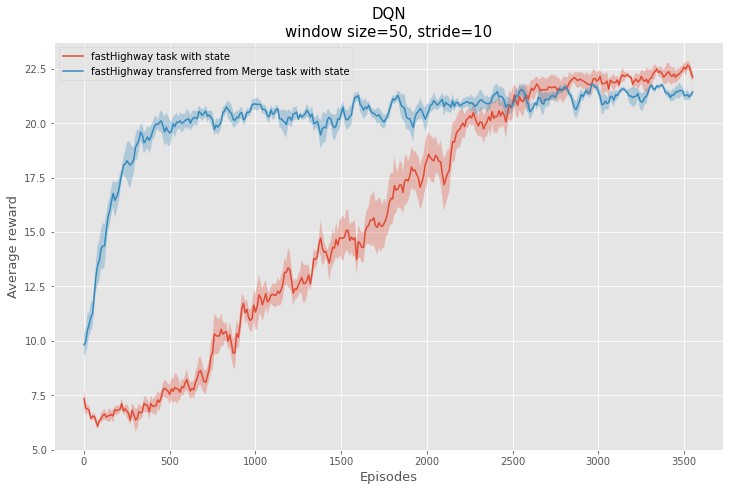

In [ ]:
df_reward_dqn_fastHighway = pd.read_excel(data_path_2 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_fastHighway = df_reward_dqn_fastHighway.T.to_numpy()
df_reward_dqn_fastHighway_transferred = pd.read_excel(data_path_3 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_fastHighway_transferred = df_reward_dqn_fastHighway_transferred.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_fastHighway, ax, title='DQN',
                                              label='fastHighway task with state', window=50, stride=10, alpha=0.3)
ax = show_and_plot().plot_training_result(episodes_rewards_fastHighway_transferred, ax, title='DQN',
                                              label='fastHighway transferred from Merge task with state', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
fig.savefig(path_HW5+'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png', dpi=300)

# **Part 4**

## merge-v0 with CNN and observation

In [ ]:
################################################################################
# This part is for solving the 'error: No available video device' and 'error: x11 not avaliable'
os.environ["SDL_VIDEODRIVER"] = "dummy"
env1 = gym.make(env_name, render_mode='rgb_array')
env1.reset()
env1.render();
os.environ['SDL_VIDEODRIVER'] = "x11"
env2 = gym.make(env_name, render_mode='rgb_array')
env2.reset()
env2.render();
################################################################################
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/4_Models_CNN_merge/'
data_path_4 = path_HW5 + 'Data_Average_Reward/4_Data_CNN_merge/'
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_merge_cnn = DQN(env, env_name, model_path, data_path_4, network_type='CNN')

### Training

In [ ]:
df_reward_dqn_merge_cnn = dqn_merge_cnn.train_with_observation(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with observation ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.51	Epsilon: 0.606
Episode 200	Average reward: 10.56	Epsilon: 0.367
Episode 300	Average reward: 10.61	Epsilon: 0.222
Episode 400	Average reward: 10.67	Epsilon: 0.135
Episode 500	Average reward: 10.72	Epsilon: 0.082
Episode 600	Average reward: 10.78	Epsilon: 0.049
Episode 700	Average reward: 10.84	Epsilon: 0.030
Episode 800	Average reward: 10.89	Epsilon: 0.018
Episode 900	Average reward: 10.94	Epsilon: 0.011
Episode 1000	Average reward: 10.98	Epsilon: 0.007
Episode 1100	Average reward: 11.02	Epsilon: 0.004
Episode 1200	Average reward: 11.05	Epsilon: 0.002
Episode 1300	Average reward: 11.08	Epsilon: 0.001
Episode 1400	Average reward: 11.11	Epsilon: 0.001
Episode 1500	Average reward: 11.13	Epsilon: 0.001
Episode 1600	Average reward: 11.17	Epsilon: 0.001
Episode 1700	Average reward: 11.22	Epsilon: 0.001
Episode 1800	Average reward: 11.27	Epsilon: 0.001
Episode 1900	Average reward: 11.31	Epsilon: 0.001
Episode 2000	Average reward: 11.36	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.99	Epsilon: 0.606
Episode 200	Average reward: 10.85	Epsilon: 0.367
Episode 300	Average reward: 10.84	Epsilon: 0.222
Episode 400	Average reward: 10.85	Epsilon: 0.135
Episode 500	Average reward: 10.87	Epsilon: 0.082
Episode 600	Average reward: 10.90	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.97	Epsilon: 0.018
Episode 900	Average reward: 11.01	Epsilon: 0.011
Episode 1000	Average reward: 11.04	Epsilon: 0.007
Episode 1100	Average reward: 11.08	Epsilon: 0.004
Episode 1200	Average reward: 11.11	Epsilon: 0.002
Episode 1300	Average reward: 11.14	Epsilon: 0.001
Episode 1400	Average reward: 11.17	Epsilon: 0.001
Episode 1500	Average reward: 11.20	Epsilon: 0.001
Episode 1600	Average reward: 11.23	Epsilon: 0.001
Episode 1700	Average reward: 11.26	Epsilon: 0.001
Episode 1800	Average reward: 11.29	Epsilon: 0.001
Episode 1900	Average reward: 11.33	Epsilon: 0.001
Episode 2000	Average reward: 11.37	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.76	Epsilon: 0.606
Episode 200	Average reward: 10.74	Epsilon: 0.367
Episode 300	Average reward: 10.73	Epsilon: 0.222
Episode 400	Average reward: 10.81	Epsilon: 0.135
Episode 500	Average reward: 10.87	Epsilon: 0.082
Episode 600	Average reward: 10.90	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.95	Epsilon: 0.018
Episode 900	Average reward: 10.97	Epsilon: 0.011
Episode 1000	Average reward: 11.00	Epsilon: 0.007
Episode 1100	Average reward: 11.03	Epsilon: 0.004
Episode 1200	Average reward: 11.06	Epsilon: 0.002
Episode 1300	Average reward: 11.11	Epsilon: 0.001
Episode 1400	Average reward: 11.17	Epsilon: 0.001
Episode 1500	Average reward: 11.21	Epsilon: 0.001
Episode 1600	Average reward: 11.25	Epsilon: 0.001
Episode 1700	Average reward: 11.28	Epsilon: 0.001
Episode 1800	Average reward: 11.31	Epsilon: 0.001
Episode 1900	Average reward: 11.34	Epsilon: 0.001
Episode 2000	Average reward: 11.36	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.60	Epsilon: 0.606
Episode 200	Average reward: 10.67	Epsilon: 0.367
Episode 300	Average reward: 10.70	Epsilon: 0.222
Episode 400	Average reward: 10.78	Epsilon: 0.135
Episode 500	Average reward: 10.84	Epsilon: 0.082
Episode 600	Average reward: 10.88	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.99	Epsilon: 0.018
Episode 900	Average reward: 11.03	Epsilon: 0.011
Episode 1000	Average reward: 11.07	Epsilon: 0.007
Episode 1100	Average reward: 11.11	Epsilon: 0.004
Episode 1200	Average reward: 11.15	Epsilon: 0.002
Episode 1300	Average reward: 11.19	Epsilon: 0.001
Episode 1400	Average reward: 11.24	Epsilon: 0.001
Episode 1500	Average reward: 11.28	Epsilon: 0.001
Episode 1600	Average reward: 11.32	Epsilon: 0.001
Episode 1700	Average reward: 11.34	Epsilon: 0.001
Episode 1800	Average reward: 11.38	Epsilon: 0.001
Episode 1900	Average reward: 11.40	Epsilon: 0.001
Episode 2000	Average reward: 11.43	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.43	Epsilon: 0.606
Episode 200	Average reward: 10.59	Epsilon: 0.367
Episode 300	Average reward: 10.66	Epsilon: 0.222
Episode 400	Average reward: 10.73	Epsilon: 0.135
Episode 500	Average reward: 10.81	Epsilon: 0.082
Episode 600	Average reward: 10.86	Epsilon: 0.049
Episode 700	Average reward: 10.92	Epsilon: 0.030
Episode 800	Average reward: 10.99	Epsilon: 0.018
Episode 900	Average reward: 11.04	Epsilon: 0.011
Episode 1000	Average reward: 11.09	Epsilon: 0.007
Episode 1100	Average reward: 11.12	Epsilon: 0.004
Episode 1200	Average reward: 11.15	Epsilon: 0.002
Episode 1300	Average reward: 11.19	Epsilon: 0.001
Episode 1400	Average reward: 11.23	Epsilon: 0.001
Episode 1500	Average reward: 11.28	Epsilon: 0.001
Episode 1600	Average reward: 11.32	Epsilon: 0.001
Episode 1700	Average reward: 11.35	Epsilon: 0.001
Episode 1800	Average reward: 11.38	Epsilon: 0.001
Episode 1900	Average reward: 11.41	Epsilon: 0.001
Episode 2000	Average reward: 11.44	Epsilon: 0.001
Episode 2

### Evaluating

In [ ]:
dqn_merge_cnn.env.config['policy_frequency'] = 10
sum_rewards = dqn_merge_cnn.evaluation(video_path+"merge_observation_CNN.mp4", evaluate_type='observation',
                                                                                  iter_num=2, evaluate_episode_num=2000, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:187
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4


Sum rewards in one EPISODE: 172.22935948833003


In [ ]:
show_and_plot().show_video(directory=video_path, file_name="merge_observation_CNN.mp4")

## **Plotting**

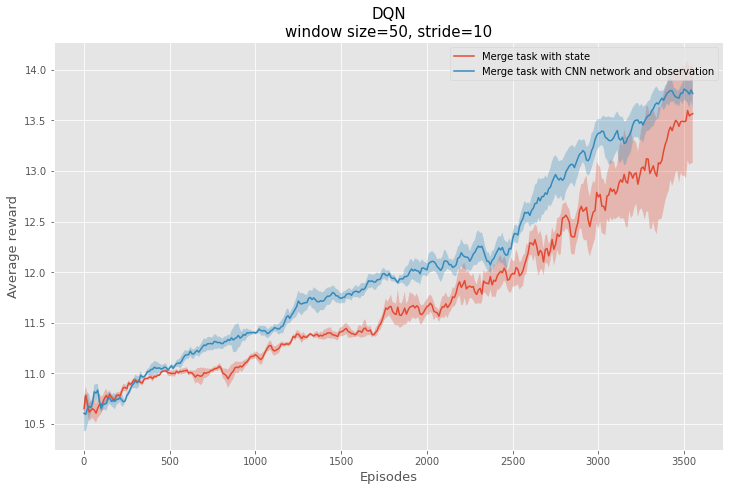

In [ ]:
df_reward_dqn_merge = pd.read_excel(data_path_1 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_merge = df_reward_dqn_merge.T.to_numpy()
df_reward_dqn_merge_cnn = pd.read_excel(data_path_4 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_merge_cnn = df_reward_dqn_merge_cnn.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_merge, ax, title='DQN', label='Merge task with state',
                                                                                                          window=50, stride=10, alpha=0.3)
ax = show_and_plot().plot_training_result(episodes_rewards_merge_cnn, ax, title='DQN', label='Merge task with CNN network and observation',
                                                                                                          window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
fig.savefig(path_HW5+'Images/3-merge_cnn_observation_merge_linear_state.png', dpi=300)

## **Checking statistical significance**

In [ ]:
t_test = ttest_ind(np.mean(episodes_rewards_merge, axis=0), np.mean(episodes_rewards_merge_cnn, axis=0))
print("P-value between two Average rewards is:", t_test.pvalue)

P-value between two Average rewards is: 2.9517602053983205e-49
